In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb
from skimage.color import rgb2gray

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, AveragePooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

def dense_block(x, num_layers, growth_rate):
    for i in range(num_layers):
        bn = BatchNormalization()(x)
        relu = ReLU()(bn)
        conv = Conv2D(4 * growth_rate, (1, 1), padding='same')(relu)
        bn = BatchNormalization()(conv)
        relu = ReLU()(bn)
        conv = Conv2D(growth_rate, (3, 3), padding='same')(relu)
        x = Concatenate()([x, conv])
    return x

def transition_layer(x, compression=0.5):
    num_filters = int(x.shape[-1] * compression)
    bn = BatchNormalization()(x)
    relu = ReLU()(bn)
    conv = Conv2D(num_filters, (1, 1), padding='same')(relu)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(conv)
    return x

def DenseNet264(input_shape, num_classes, growth_rate=32):
    inputs = Input(shape=input_shape)

    # Initial Convolution Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=(2, 2))(x)

    # Dense Block 1
    x = dense_block(x, 6, growth_rate)
    x = transition_layer(x)

    # Dense Block 2
    x = dense_block(x, 12, growth_rate)
    x = transition_layer(x)

    # Dense Block 3
    x = dense_block(x, 64, growth_rate)
    x = transition_layer(x)

    # Dense Block 4
    x = dense_block(x, 48, growth_rate)

    # Final layers
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Use the DenseNet264 model
input_shape = (224, 224, 3)
num_classes = 4
model = DenseNet264(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [3]:
batch_size = 32
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'alzheimer/training',  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['MildDemented','NonDemented','VeryMildDementedd','ModerateDemented'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')


valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

Found 0 images belonging to 4 classes.


In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = r'D:\Data',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 86436 images belonging to 4 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'D:\Data',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 17286 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


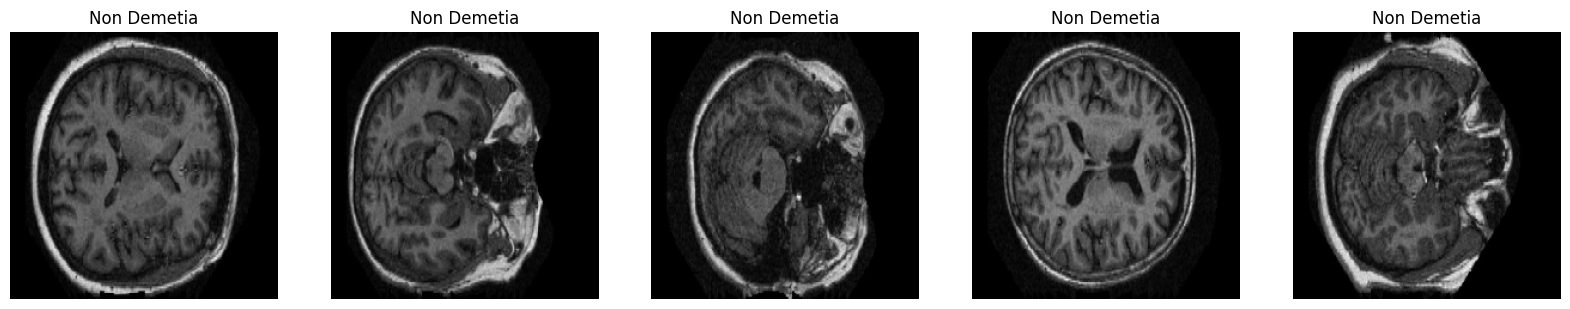

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(50)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [10]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Second convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Third convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Fifth convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Flatten the output of the convolutional layers to 1D
    tf.keras.layers.Flatten(),
    
    # Fully connected (dense) layer
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output layer (4 classes for dementia types)
    tf.keras.layers.Dense(4, activation='softmax')
])




In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_264 (Conv2D)                  │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_265 (Conv2D)                  │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_266 (Conv2D)                  │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_267 (Conv2D)                  │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_268 (Conv2D)                  │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,884 (1.16 MB)

 Trainable params: 302,884 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.optimizers import RMSprop

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

total_sample = train_generator.n


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your generator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'D:\Data',  
    target_size=(224, 224),   # Consistent with model input shape
    batch_size=32,
    class_mode='categorical'
)


# Define your total sample size
total_sample = len(train_generator.filenames)
batch_size = 32  # Define your batch size

n_epochs = 30    # Define the number of epochs

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=int(total_sample / batch_size),
    epochs=n_epochs,
    verbose=1
)
model.save('model264.keras')

Found 86436 images belonging to 4 classes.
Epoch 1/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 3274s 1s/step - accuracy: 0.8253 - loss: 0.4837
Epoch 2/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 1s 30us/step - accuracy: 0.9688 - loss: 0.0271    
Epoch 3/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 2314s 855ms/step - accuracy: 0.9827 - loss: 0.0524
Epoch 4/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.9375 - loss: 0.1176    
Epoch 5/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 1905s 704ms/step - accuracy: 0.9917 - loss: 0.0261
Epoch 6/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 1.0000 - loss: 0.0074    
Epoch 7/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 1945s 718ms/step - accuracy: 0.9944 - loss: 0.0219
Epoch 8/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 1.0000 - loss: 3.5272e-06    
Epoch 9/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 1779s 658ms/step - accuracy: 0.9959 - loss: 0.0152
Epoch 10/30
2701/2701 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 1.0000 - loss: 5.1328e-05    
Epoch 11/30
2701/2701 ━━━

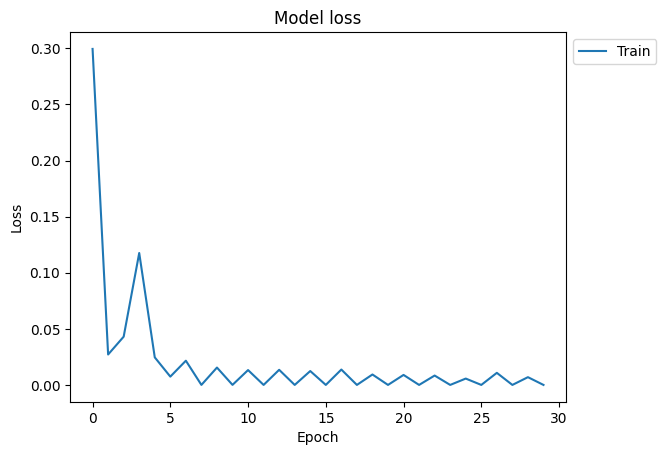

In [15]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left', bbox_to_anchor=(1,1))

plt.show()

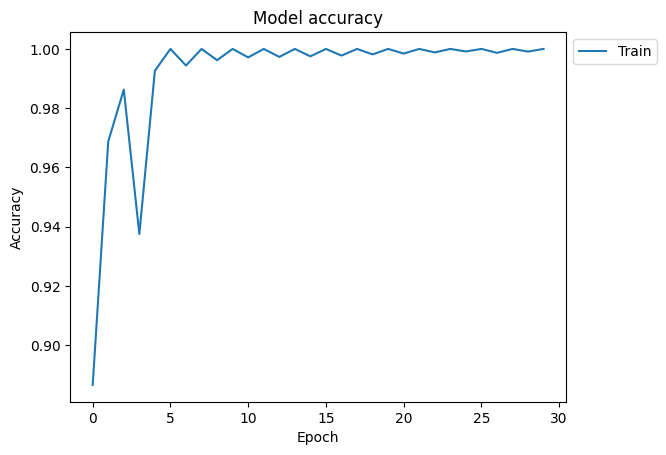

In [16]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [17]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define paths
# source_folder = 'D:/Data'  # Your source folder with class subfolders
# train_folder = 'D:/training_data'
# test_folder = 'D:/testing_data'

# # Class names based on your directory structure
# classes = ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

# # Create training and testing folders with subfolders
# for class_name in classes:
#     os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
#     os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

# # Split data for each class
# for class_name in classes:
#     # List all images in the class directory
#     class_dir = os.path.join(source_folder, class_name)
#     images = os.listdir(class_dir)

#     # Split the images into 80% training and 20% testing
#     train_images, test_images = train_test_split(images, test_size=0.2)

#     # Move images to the respective training and testing folders
#     for img in train_images:
#         shutil.copy(os.path.join(class_dir, img), os.path.join(train_folder, class_name, img))
    
#     for img in test_images:
#         shutil.copy(os.path.join(class_dir, img), os.path.join(test_folder, class_name, img))

# print("Data split complete!")


Data split complete!


In [18]:
test_dataset  = test_datagen.flow_from_directory(directory = r'D:/training_data',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 83018 images belonging to 4 classes.


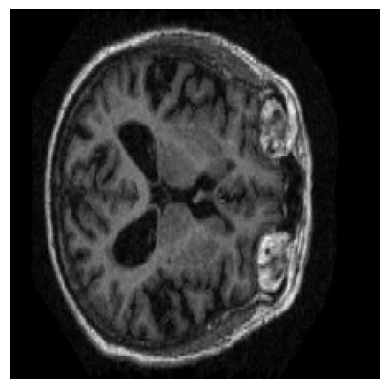

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Prediction: Non Demented


In [19]:
import numpy as np
from keras_preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Map class indices to labels
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load and preprocess the image
img = load_img(r'D:\testing_data\Non Demented\OAS1_0001_MR1_mpr-2_134.jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the input shape expected by the model
img = np.expand_dims(img, axis=0)

# Predict the class of the image
result = model.predict(img)

# Map the prediction to a label
predicted_class = np.argmax(result, axis=1)[0]
prediction = idc[predicted_class]

print(f"Prediction: {prediction}")

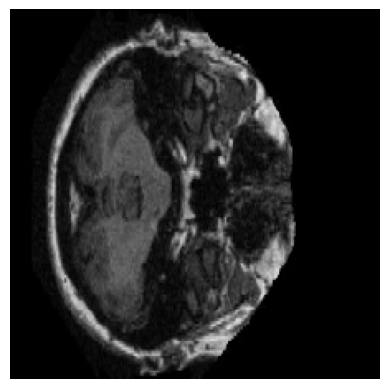

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction: Moderate Dementia


In [20]:

import numpy as np
from keras_preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Map class indices to labels
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load and preprocess the image
img = load_img(r'D:\testing_data\Moderate Dementia\OAS1_0308_MR1_mpr-2_108.jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the input shape expected by the model
img = np.expand_dims(img, axis=0)

# Predict the class of the image
result = model.predict(img)

# Map the prediction to a label
predicted_class = np.argmax(result, axis=1)[0]
prediction = idc[predicted_class]

print(f"Prediction: {prediction}")

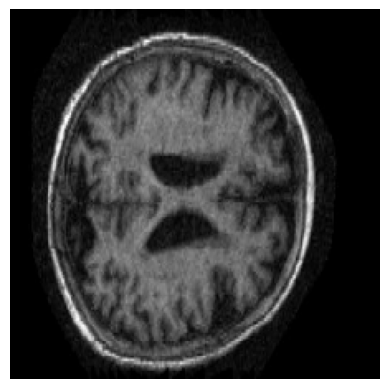

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: Mild Dementia


In [21]:
import numpy as np
from keras_preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Map class indices to labels
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load and preprocess the image
img = load_img(r'D:\testing_data\Mild Dementia\OAS1_0028_MR1_mpr-4_156.jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the input shape expected by the model
img = np.expand_dims(img, axis=0)

# Predict the class of the image
result = model.predict(img)

# Map the prediction to a label
predicted_class = np.argmax(result, axis=1)[0]
prediction = idc[predicted_class]

print(f"Prediction: {prediction}")

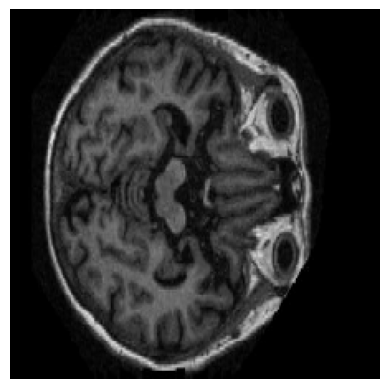

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: Very mild Dementia


In [22]:

import numpy as np
from keras_preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Map class indices to labels
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load and preprocess the image
img = load_img(r'D:\testing_data\Very mild Dementia\OAS1_0003_MR1_mpr-3_143.jpg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # Normalize the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the input shape expected by the model
img = np.expand_dims(img, axis=0)

# Predict the class of the image
result = model.predict(img)

# Map the prediction to a label
predicted_class = np.argmax(result, axis=1)[0]
prediction = idc[predicted_class]

print(f"Prediction: {prediction}")

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale test images like training

test_generator = test_datagen.flow_from_directory(
    'D:/testing_data',  # Path to your test dataset
    target_size=(224, 224),  # Image size consistent with the model input
    batch_size=32,
    class_mode='categorical',  # Assuming you're using categorical labels
    shuffle=False  # Do not shuffle, so predictions match the image order
)


Found 31160 images belonging to 4 classes.


In [24]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


974/974 ━━━━━━━━━━━━━━━━━━━━ 642s 659ms/step - accuracy: 0.9998 - loss: 9.4232e-04
Test Loss: 0.0006951909163035452
Test Accuracy: 0.9998074173927307


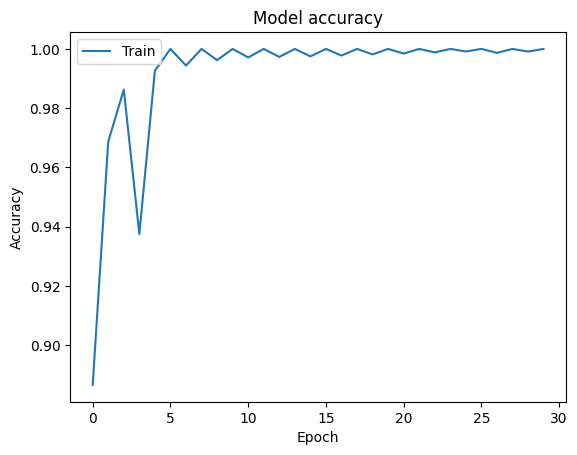

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
